Hands On Machine Learning 스터디 (2021-02-28)  
발표자 : 임지연  

#6. Decision Tree
: 분류와 회귀, 다중출력(multi-label classification)도 가능한 다재다능 알고리즘  

장점: 데이터 전처리가 거의 필요하지 않다. column간의 스케일을 맞출 필요가 없고, 평균을 원점에 맞추는 작업이 필요하지 않다.
  
(1)	Decision Tree의 학습, 시각화, 예측방법  
(2)	CART 알고리즘  
(3)	Decision Tree에 규제를 가하는 법  
(4)	회귀문제에 적용하기  
(5)	Decision Tree의 제약사항  

##(1) Decision Tree의 학습,시각화,해석

### - Scikit-learn을 이용한 학습

In [ ]:
import pandas as pd
import numpy as np

from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()  ## iris는 dictionary와 유사한 bunch 형식으로 저장되어있음 (dot notation으로 value 호출가능)

X = iris.data[:,2:]  ## 4개 변수 중 2개 칼럼만 선택
y = iris.target   ## 0,1,2의 값을 갖는 분류 label

tree_clf = DecisionTreeClassifier(max_depth=2)  ## 결정트리의 가지를 2개까지만 만드는 것임. 직관적으로 차원을 나누는 평면이 2개인 것
tree_clf.fit(X,y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

###- 트리 시각화

In [ ]:
from sklearn.tree import export_graphviz

export_graphviz(tree_clf, 
                out_file = "iris_tree.dot",
                feature_names = iris.feature_names[2:],
                class_names = iris.target_names,
                rounded = True,           ## 박스 코너 동그랗게
                filled = True             ## 노드의 명도로 해당 label로 분류된 데이터 수를 표현
                )

'''
export_graphviz 파일의 확장자는 .dot이지만
만약 그림을 pdf나 png로 바꾸고 싶다면 아래 코드를 이용합니다.

$dot -Tpng iris_tree.dot -o iris_tree.png

'''

###- Decision Tree의 해석  
  
CART 이진분류 알고리즘을 예시로 Decision Tree의 분류과정을 살펴보기

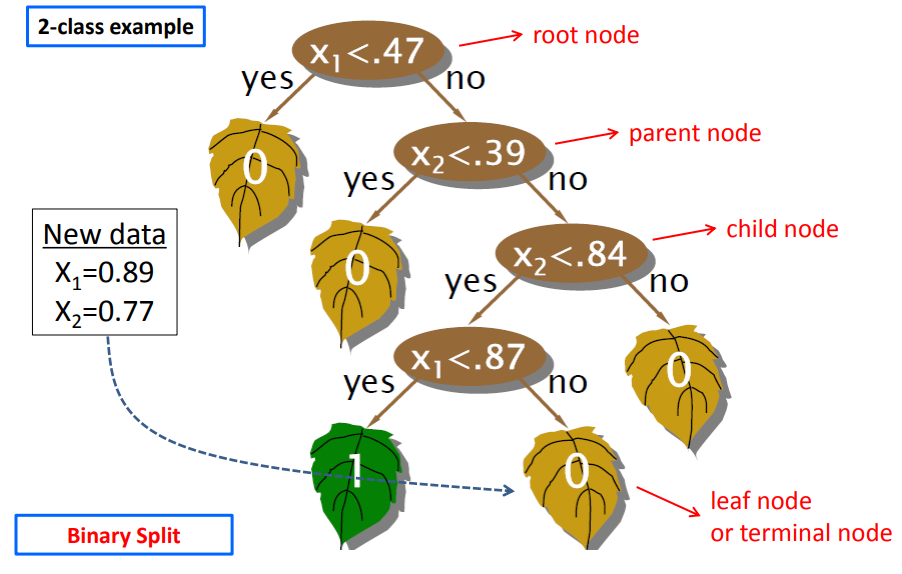

iris 데이터의 Decision Tree를 해석해보자  
  
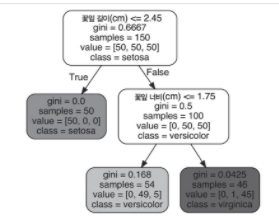



1.   gini = 불순도 (지니 지수 = Gini Impurity) 
2.   sample = 해당 노드의 학습 데이터 수
3.   value = 각 class로 분류된 데이터 수
4.   class = 해당 노드가 어떤 class로 데이터를 분류하는가



참고 : Decision Tree에서 불순도를 측정하는 방법은 여러가지이나 이번 예제에서는 Gini Impurity를 사용함.     
<br>
<center>
<font size = "5">
Gini(D) = 1−	$\sum_{i = 1}^{k} (p_{i})^2 $
</font></center>
<br>
Iris 예제에서 versicolor로 분류된 노드의 Gini Impurity는 아래와 같이 계산될 수 있음. 

In [ ]:
gini_impurity = 1 - (0/54)**2 - (49/54)**2
print(gini_impurity)

0.17661179698216734


Decision Tree는 각 노드의 불순도를 최소화하는 방향으로 class를 결정하게 된다. 
setosa로 분류되는 노드와 같이 불순도가 0인 노드를 순수노드라고 부름. 순수노드는 Decision Tree의 Stopping Rule 기준임.

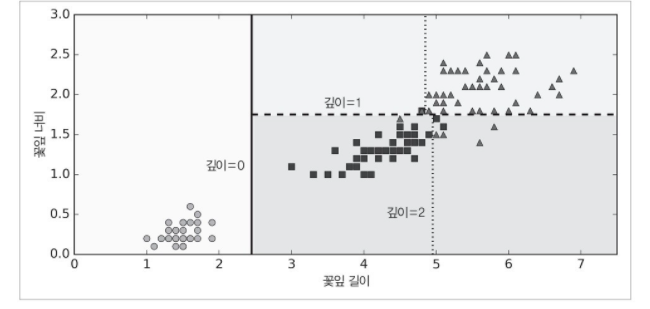

###- 클래스 분류 확률 구하기
: 새로운 input data x가 특정 클래스에 속할 확률을 구해보자!  
 이 경우 root node부터 x의 변수값들을 비교해가며 x가 궁극적으로 속하는 leaf node를 찾을 수 있을 것임. 해당 leaf node의  분류 개수에 기반한 empirical probability를 클래스 분류 확률로 추정하여 사용.
  
Scikit-learn을 이용해서 다음과 같이 손쉽게 구할 수 있음.


In [ ]:
tree_clf.predict_proba([[5,1.5]])  ## 변수값 대입 (학습데이터 X가 2d array였기 때문에 똑같이 맞춰줌)

array([[0.        , 0.90740741, 0.09259259]])

각 column이 5, 1.5의 값을 갖는 데이터는 약 90%의 확률로 class 1 에 속한다고 말할 수 있음.

In [ ]:
tree_clf.predict([[5, 1.5]])  ## tree predict 함수는 array 형식의 output을 리턴함

array([1])

##(2) CART 알고리즘

Decision Tree Classification의 방법론은 다양하며, 그 중 CART는 반드시 2개의 하위 노드로 나누어지는 이진분류 방법에 해당합니다.  

CART 알고리즘은 학습 데이터에서 Gini Impurity (or whatever the criterion is)를 최소로 만드는 특성 k의 임곗값 $t_{k}$을 기준으로 데이터를 분류해나간다. 이 때 Decision Tree가 최소화해야 하는 비용함수 J(k,$t_{k}$)를 식으로 나타내면 아래와 같다.


<br/>
&nbsp;&nbsp;&nbsp;
<center>
<font size = "5">
J(k,$t_{k}$) =$\frac{m_{left}}{m}*G_{left}$ + $\frac{m_{right}}{m}*G_{right}$  
</font>   
<br/>  




  
&nbsp;&nbsp;&nbsp;&nbsp;
##(3) Decision Tree에 규제를 가하는 법  
- ml에서 규제를 가한다는 건 overfitting을 막기 위해서 그다지 유의하지 않은 분류기 요소들을 쳐낸다는 소리  
- Decision Tree는 depth가 깊어질수록 overfitting됨
- 그래서 depth가 너무 깊어지지 않게 leaf node를 쳐주는 작업이 필요한데, 그걸 Pruning (가지치기)라고 부름

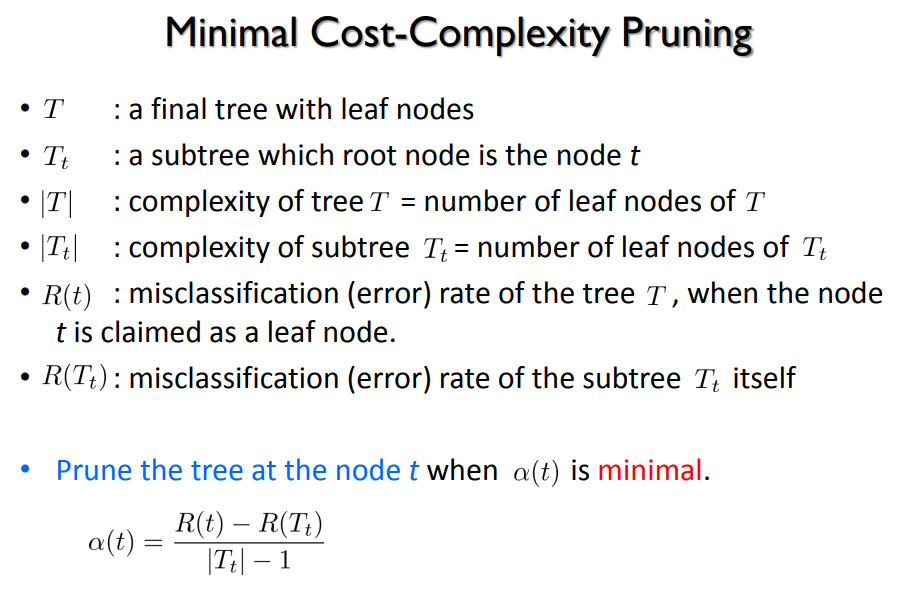

- $a(t)$는 effective alpha로 불리며 각 노드의 성능을 나타낸다. (노드의 분류 성능이 좋을수록 effective alpha값도 높게 계산됨)
- 따라서 Pruning은 effective alpha가 가장 낮은 노드를 잘라내는 과정  

&nbsp;&nbsp;&nbsp;&nbsp;

그렇다면 Python에서는 Pruning을 어떻게 구현해야 할까?  
Scikit-learn 공식문서에서 소개하는 예시를 통해 알아보자.

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier

X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

clf = DecisionTreeClassifier(random_state=0)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities  ##ccp_alpha가 복잡도를 판별하는 지표

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

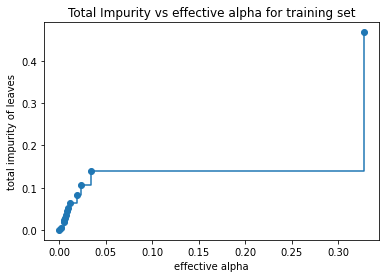

In [ ]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas, impurities, marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

불순도의 합과 effective alpha는 반비례 관계인 것이 보여짐 (우리가 예상한대로)

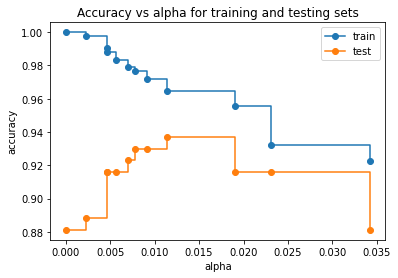

In [ ]:
### alpha는 test data의 정확도를 가장 높게 할 수 있는 것으로 선택
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [ ]:
https://datascience.stackexchange.com/questions/25666/what-are-limitations-of-decision-tree-approaches-to-data-analysis/25997#:~:text=The%20major%20limitations%20of%20decision,issues%20with%20highly%20collinear%20predictors.

##(4) 회귀 문제에 적용하기

: CART 알고리즘을 회귀에 적용하면 기본적인 부분은 똑같이 전개되지만, 불순도를 평가하는 방식과 최종 leaf의 값을 어떻게 산출할 것인지 그 기준만 변경해주면 됩니다. 
Tree Regression의 과정을 단계별로 설명한 문서를 첨부합니다.

https://www.saedsayad.com/decision_tree_reg.htm


##(5) Decision Tree의 제약사항

다재다능하고 해석이 쉬운 장점이 있는 Decision Tree이지만, 만능 알고리즘이 될 수는 없습니다. 일반적으로 해석이 쉬운 모델은 정교한 예측을 포기하게 되는 약점을 가지고 있습니다. Decision Tree의 단점도 비슷합니다. 

Decision Tree의 단점
- 낮은 예측력 (특히 회귀에 있어)
- 부분 최적값에 빠짐 ( train-test set을 어떻게 나누는가에 따라 모델이 천차만별로 달라질 수 있음)
- 탐색 공간이 클 경우 계산 복잡도가 큼
- 변수 간 교호작용이 고려되지 않음
- 선형성이 고려되지 않음
(https://datascience.stackexchange.com/questions/6787/are-decision-tree-algorithms-linear-or-nonlinear)


Decision Tree의 약점을 보완하기 위한 모형

- Bagging
: Bootstrap을 이용해 무수히 많은 모델을 만ㄹ들어내고, 이러한 모델의 평균치를 최종 모델로 사용함 (Bagging에서는 Pruning을 사용하지 않음) Bagging의 문제라면 여러 모델의 평균치를 활용했기 때문에 해석력이 낮아졌다는 것...
- Random Forest
: feature 중 랜덤하게 n개만 뽑아서 그 변수들로 모형을 만들고 평균치를 냄.
이러한 방법을 사용하는 이유는, 변수 전체를 가지고 bagging을 할 경우 적어도 한 변수가 아주 유의미할 경우, 해당 변수에서 split이 시작될 것이고 이렇게 되면 나머지 node들도 비슷해질 가능성이 높기 때문. 만들어진 tree 간의 유사도를 줄이기 위해 일부러 전체 feature가 아닌 일부만 사용함.
- Boosting

